Group 6:
- Tim Angevare
- Pjottr van Zee
- Tion Zijlstra
- Lilla Mikovics
- Pascal Bakker
- Cristian Haidău

https://github.com/TimAngevare/AnonMarketWebscraper

In [1]:
import requests
from requests.exceptions import ProxyError
from time import sleep
from bs4 import BeautifulSoup

Set up the proxy and see if it works. A tor service was installed on the computer on port 9050. We need to set this up in the code and connect to access the dark web

In [2]:
proxies = {
    'http' : 'socks5h://127.0.0.1:9050',
    'https' : 'socks5h://127.0.0.1:9050'
}
ip = requests.get('https://ident.me').text

spoofedIP = requests.get('https://ident.me',proxies=proxies).text

print('Your ip: ' + ip.split('.')[-1] + '\nYour spoofed ip: ' + spoofedIP.split('.')[-1])

Your ip: 2001:67c:2564:a315:b0e7:600e:f3ec:f88
Your spoofed ip: 133


Are we configured to use Tor?

In [3]:
requests.get('https://check.torproject.org/', proxies=proxies).text.find("Congratulations. This browser is configured to use Tor.") != -1

True

Lets fetch our marketplace Anon market

In [4]:
onion_url = 'http://2r7wa5og3ly4umqhmmqqytae6bufl5ql5kz7sorndpqtrkc2ri7tohad.onion'

try:
    browser = requests.session()
    browser.headers = {
        'Accept':    'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
'Accept-Encoding':    'gzip, deflate',
'Accept-Language':    'en-us,en;q=0.5',
'User-Agent':         'Mozilla/5.0 (Windows NT 6.1; rv:24.0) Gecko/20100101 Firefox/24.0'
    }
    response = browser.get(onion_url, proxies=proxies, timeout=30, allow_redirects=True)
    while True:
        sleep(1)
        if response.text.find("DDoS") == -1:
            break
        else:
            print(response.history)
    
    # Process the response here
except ProxyError as e:
    print(f"Error: {e}")

Add the different catergories of drugs

In [5]:
categories_list = []

soup = BeautifulSoup(response.content, 'html.parser')
drug_categories = soup.find_all('div', class_="subcat_1")

for div in drug_categories:
    if div.text.find('View all') == -1:
        category = div.text.strip()
        a_tag = div.parent
        url = onion_url + a_tag['href']
        dic = {"name" : category, "url" : url, "pages" : 0, "posts" : []}
        categories_list.append(dic)

Create a function to scrape the information of each post on the page

In [6]:
def scrape_page(page, category):
    post_section = page.find('div', class_='items')
    posts = post_section.find_all('div', class_='item')
    for post in posts:
        url = category["url"] + post.contents[1]['href']
        seller = post.find('a', class_='seller').text.strip()
        title = post.find('div', class_='title').text.strip()
        price = post.find('div', class_='price').text.strip().split(' ')[0]
        tbody = post.find('table')
        stars = tbody.find('div', class_='stars2')['style'].split(':')[-1]
        stars = round(float(stars[:-1]))
        post_data = {'title' : title, 'url' : url, 'seller' : seller, 'price' : price, 'stars' : stars}
        category['posts'].append(post_data)

Now we scrape the categories for info and add the page numbers

In [ ]:
for category in categories_list: 
        print(category["name"])
        response = browser.get(category["url"], proxies=proxies, timeout=20, allow_redirects=False)
        soup = BeautifulSoup(response.content, 'html.parser')
        category["pages"] = soup.find_all('div', class_='page')[-1].text.strip()
        for i in range(1, int(category["pages"]) + 1):
            try:
                page = browser.get(category["url"] + '/' + str(i) + '/', proxies=proxies, timeout=20, allow_redirects=False)
                page = BeautifulSoup(page.content, 'html.parser')
                scrape_page(page, category)
            except (requests.exceptions.ConnectionError, requests.exceptions.RequestException) as e:
                 print("ran into a connection issue: ", e)
                 sleep(5)


Lets export it to csv file

In [28]:
import pandas as pd

transformed_data = []
for category in categories_list:
    category_name = category['name']
    posts = category['posts']
    for post in posts:
        post_attributes = {
            'category': category_name,
            'title': post['title'],
            'url': post['url'],
            'seller': post['seller'],
            'price': post['price'],
            'rating': post['stars']
        }
        transformed_data.append(post_attributes)

# Create a Pandas DataFrame
df = pd.DataFrame(transformed_data)
df.to_csv("posts.csv")


In [29]:

df = pd.read_csv("posts.csv")

Clean the price value to take out the , in 1000

In [42]:
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'], errors='coerce')

df.describe()

,Unnamed: 0,price,rating
count,43862.00000,4.386200e+04,43862.000000
mean,21930.50000,1.007023e+04,20.755324
std,12662.01309,9.550558e+05,39.713331
min,0.00000,5.000000e+00,0.000000
25%,10965.25000,4.700000e+01,0.000000
50%,21930.50000,1.245600e+02,0.000000
75%,32895.75000,3.890000e+02,0.000000
max,43861.00000,1.000000e+08,100.000000


Sellers

In [31]:
seller_df = {
    'name' : [],
    'posts' : [],
    'rating' : []
}

for sellerName in df['seller'].unique():
    seller_df['name'].append(sellerName)
    posts = df[df.seller == sellerName]
    postsCount = len(posts)
    seller_df['posts'].append(postsCount)
    avgReview = posts['rating'].mean()
    seller_df['rating'].append(avgReview)

seller_df = pd.DataFrame(seller_df).sort_values(by="posts", ascending=False)

seller_df.head(20)

,name,posts,rating
44,cannabiz,1004,1.494024
195,sportlife,687,10.681223
361,strainpirate,658,50.322188
126,nextlevel,551,11.542650
53,donalddrugs,534,30.102996
49,cindicator,526,0.760456
210,coffeeshop,490,13.948980
22,britishstandard,411,34.257908
136,digitalsin,373,2.144772
71,mastermeds,373,0.000000


Hereby I believe the police should further investigate the top 3 sellers identified above. Taking them down would have to most impact in the drug world as they are responsible for the most volume.

Start making graphs

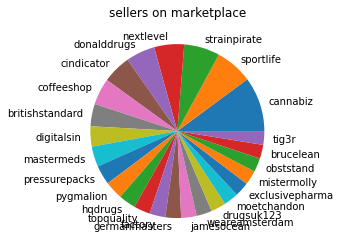

In [36]:
import matplotlib.pyplot as plt

seller_small = seller_df.head(25)
y = seller_small['posts']
labels = seller_small['name']

plt.pie(y, labels = labels)
plt.title("sellers on marketplace")
plt.show() 

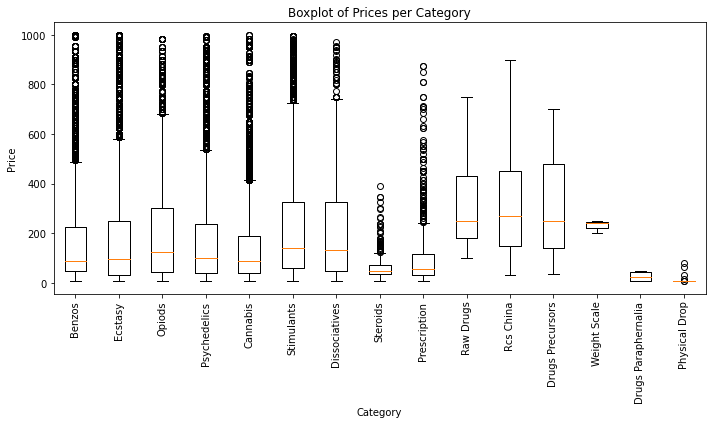

In [38]:
data = []
categories = []
for cat in df['category'].unique():
    posts = df[df['category'] == cat]
    price = posts['price']
    price = price[price < 1000]
    data.append(price)
    categories.append(cat)


plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.boxplot(data, labels=categories)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel("Category")
plt.ylabel("Price")
plt.title("Boxplot of Prices per Category")
plt.tight_layout()
plt.show()

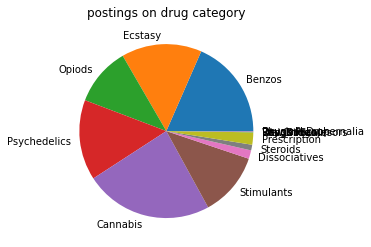

In [43]:
count = []
for i in data:
    count.append(len(i))
plt.pie(count, labels = categories)
plt.title("postings on drug category")
plt.show() 


What surprised us the most in general is that the dark web is not only a place to purchase illegal goods but also for legal ones. This analysis was done on drugs, but the same marketplace also contains courses for finance. Forged clothes (2nd link) were also something we did not expect to have a marketplace, as we believed that this could also be sold on the clearnet. Lastly, it was interesting to see that alcohol still has a place on the black market.

- http://2r7wa5og3ly4umqhmmqqytae6bufl5ql5kz7sorndpqtrkc2ri7tohad.onion/product/ELMPnqQjPCfeiEZixwLepxdBP5KKnlvi
- http://2r7wa5og3ly4umqhmmqqytae6bufl5ql5kz7sorndpqtrkc2ri7tohad.onion/product/gGXwg9Wt0KBkMbAQ94AMvaEOlTptCKlY
- http://2r7wa5og3ly4umqhmmqqytae6bufl5ql5kz7sorndpqtrkc2ri7tohad.onion/product/CTnLMQqnc0XSduJNtrd3UM11A2vu0yqa

What was found, is that although cannabis has become legal in a lot of countries, it is still the biggest by number of postings. Out guess is that due to an easy manufacturing and lower risk with retrospect to hard drugs it is the easiest to export. Shortcomings were found in that on the posts there is no field for quantity. The quantity is usually in the description, but even here there is no exact format for quantity. For example a gram is referred to as 'gram', 'g', 'gr' among others. Because of this the analysis on price does not work. A price of 1000 is an outlier but maybe this is because of 10x as much volume for one posting. It was difficult to find a marketplace to scrape as most require a captcha which can not be bypassed by a bot.

In conclusion, this code provides a nice basis to further build on. Further research includes selecting a better marketplace for analysis. It would also be helpful to store the summarising statistics so an analysis can be done on how the marketplace develops over time.